In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pyrtools as pt
import plenoptic as po
from plenoptic.tools import to_numpy


%load_ext autoreload
%autoreload 2

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

# A few test images
on small images we can rapidly compute the Jacobain

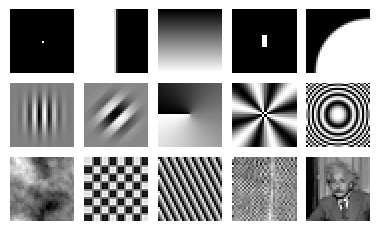

In [2]:
size = 32
stimuli = po.tools.make_basic_stimuli(size)
po.imshow(stimuli, title=None, col_wrap=5, zoom=2);

## Defining/choosing a model

In [6]:
# simplest models
L = po.simul.Linear()
LN = po.simul.LinearNonlinear(kernel_size=(7, 7))

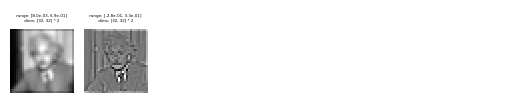

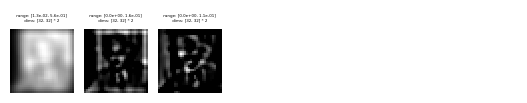

/Users/lyndonduong/Documents/Python_External/plenoptic/plenoptic/simulate/canonical_computations/steerable_pyramid_freq.py:325: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:590.)
  imdft = torch.rfft(x, signal_ndim=2, onesided=False, normalized=self.fft_normalize)
/Users/lyndonduong/Documents/Python_External/plenoptic/plenoptic/simulate/canonical_computations/steerable_pyramid_freq.py:332: UserWarning: The function torch.ifft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.ifftn. (Triggered internally at  ../aten/src/ATen/native/SpectralOps.cpp:578.)
  hi0 = torch.ifft(hi0, signal_ndim=2, normalized=self.fft_normalize)


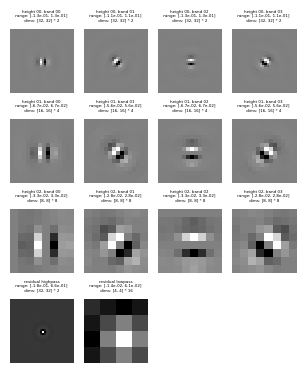

In [7]:
po.imshow(L(stimuli), zoom=4, batch_idx=14);
po.imshow(LN(stimuli), zoom=4, batch_idx=14);
po.imshow(FE(stimuli), zoom=4, batch_idx=14);

## Input output Jacobian (aka. first order Taylor)

Exhaustive construction of the input output Jacobian evaluated at this image takes about a minute

In [5]:
# Note: making sure to define the tensors without breaking the graph
i = 14
model = FE


x = torch.tensor(stimuli[i]).unsqueeze(0)
x_flat = x.flatten().unsqueeze(1).requires_grad_()
# y_flat = torch.cat([s.squeeze().view(-1) for s in model(x_flat.view_as(x)).values()]).unsqueeze(1)
y_flat = model(x_flat.view_as(x)).flatten().unsqueeze(1)
J = po.synth.autodiff.jacobian(y_flat, x_flat)

(2048, 1024)


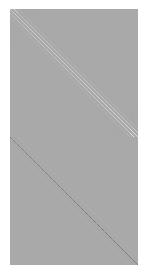

In [6]:
J = po.to_numpy(J)
print(J.shape) # out by in, tall and skinny matrix, overcomplete representation
pt.imshow(J, zoom=.125, title=None);

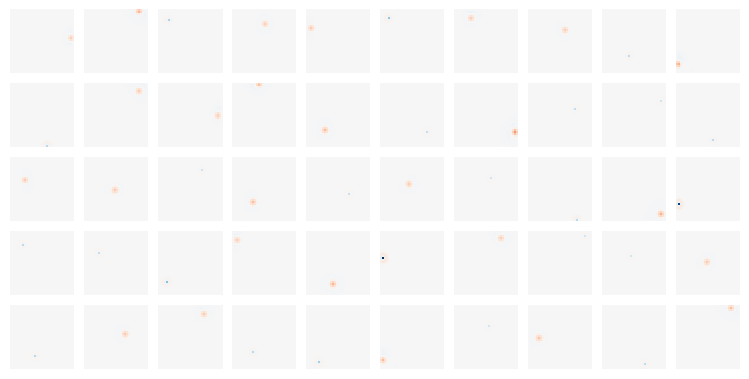

In [7]:
# visualization of some random channels
# as expected
N = 50
random_lines_J = J[np.random.choice(np.arange(len(J)), N, replace=False)]
pt.imshow([l.reshape(size, size) for l in random_lines_J], vrange='auto0', col_wrap=10, title=None, zoom=2);

In [8]:
# TODO show how it adapts to the content of the image

## SVD of the Jacobian

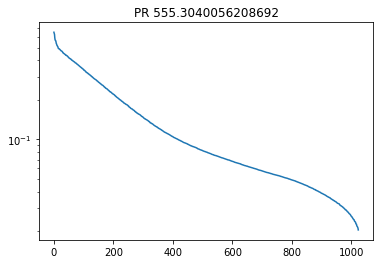

In [9]:
# computing the svd
U,s,Vh = np.linalg.svd(J)
# Note that svd returns the conjugate transpose of V,
# columns of V form a basis of the input space
# so here we need to look as rows of Vh (its real valued).

# a way to think about effective dimensionality
participation_ratio = (s.sum() ** 2 / (s ** 2).sum())

plt.plot(s)
# indicating where nullspace roughly starts
# threshold = np.where(np.log(s) < -20)[0].min()
# plt.axvline(threshold)
plt.yscale('log')
plt.title('PR '+ str(participation_ratio))
plt.show()

The dominant eigenvectors, aka. the visible eigendistortions

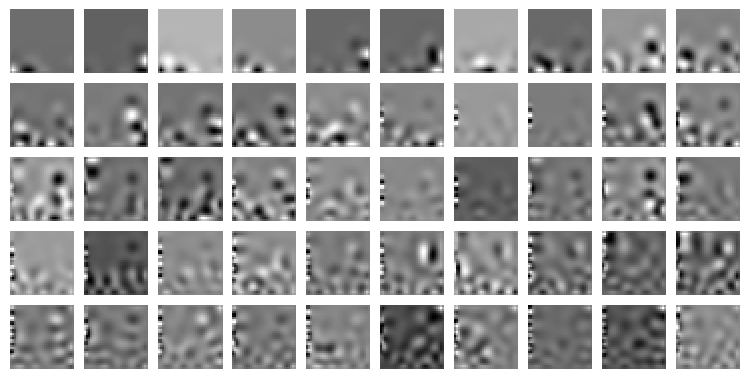

In [10]:
pt.imshow([v.reshape(size, size) for v in Vh[:N]],
          title=None, col_wrap=10, zoom=2);

In [11]:
# looking at some basis vectors of the column space (reweighted for fun)

# prob = (s[:threshold])
# prob /= prob.sum()
# random_colspace = Vh[np.random.choice(np.arange(0, threshold, 1), N, replace=False, p=prob)]

# pt.imshow(random_colspace.reshape(N, *image.shape),
#           title=None, col_wrap=10, zoom=1);

Looking at some of the basis vectors of the nullspace.

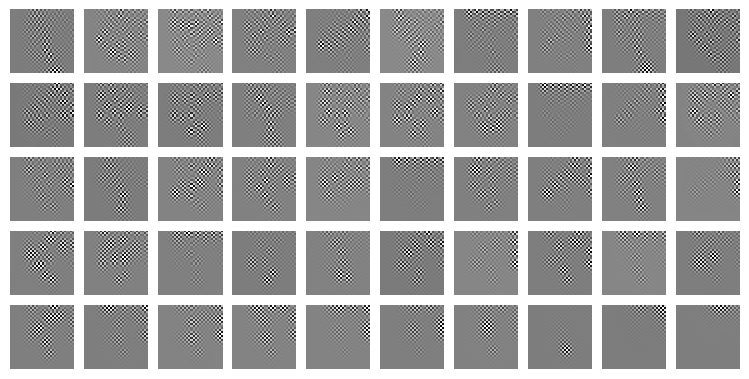

In [12]:
pt.imshow([v.reshape(size, size) for v in Vh[-N:]],
          title=None, col_wrap=10, zoom=2);

In [13]:
# some other random hardly visible distortions

# random_nullspace = Vh[np.random.choice(np.arange(threshold, len(Vh), 1), N, replace=False)]
# pt.imshow(random_nullspace.reshape(N, size, size),
#           title=None, col_wrap=10, zoom=1);